# Digit AI Trainer
#### How-to:
- Paste function into last cell
- Run all cells

In [1]:
import torch
from fastai.vision.all import *
import logging
import time
import numpy as np
from sklearn.metrics import accuracy_score
import torch.nn as nn
from collections import OrderedDict


def summary(model, input_size, batch_size=-1, device="cuda"):
# Copied from torchsummary
    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. )
    total_output_size = abs(2. * total_output * 4. )  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4.)
    estimated_size = total_params_size + total_output_size + total_input_size

    # total_size_str = "Estimated Total Size (MB): %0.2f" % total_size
    return estimated_size

def format_elapsed_time(start_time, end_time):
    # Calculate the time difference in seconds
    delta_time = end_time - start_time

    # Convert to minutes and hours if necessary
    if delta_time >= 3600:  # If delta_time is greater than or equal to 1 hour
        hours = int(delta_time // 3600)
        delta_time %= 3600
    else:
        hours = 0

    if delta_time >= 60:  # If delta_time is greater than or equal to 1 minute
        minutes = int(delta_time // 60)
        delta_time %= 60
    else:
        minutes = 0

    seconds = delta_time  # Remaining time in seconds
    formatted_seconds = f"{seconds:.2f}"  # Format seconds with 2 decimal places

    # Construct and return the formatted string
    return f"{hours} hours, {minutes} minutes, {formatted_seconds} seconds"

def save_confusion_matrix(interp, pic_path, cmap:str="Blues"):
    title = "Confusion Matrix"
    "Plot the confusion matrix, with `title` and using `cmap`."
    # This function is mainly copied from the sklearn docs
    cm = interp.confusion_matrix()
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(interp.vocab))
    plt.xticks(tick_marks, interp.vocab, rotation=90)
    plt.yticks(tick_marks, interp.vocab, rotation=0)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white"
                    if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(interp.vocab)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    fig.savefig(pic_path)

def train_model(digit_folder="Projects/digit/digits", batch_size=32, epochs=12, seed=69, lr=3e-3, model_output="Projects/digit/models.pkl", save_conf=False, conf_out='None', base_model="resnet18"):
    # Logging
    torch.cuda.empty_cache()
    log_name = model_output.replace(".pkl", ".txt")
    logging.getLogger().handlers = []
    logging.basicConfig(level=logging.INFO)
    file_handler = logging.FileHandler(log_name)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', '%H:%M:%S')
    file_handler.setFormatter(formatter)
    logging.getLogger().addHandler(file_handler)
    with open(log_name, 'w'):
        pass
    logging.info('Logger setup')
    
    # Setup device
    available = torch.cuda.is_available()
    logging.info(f'CUDA: {available}')
    device = torch.device('cuda' if available else 'cpu')
    if available:
        logging.info(f"Device: {torch.cuda.get_device_name(device)}")
    else:
        logging.info("Using CPU")

    model_map = {
        'AlexNet': models.alexnet,
        'DenseNet121': models.densenet121,
        'EfficientNet_b0': models.efficientnet_b0,
        'EfficientNet_b1': models.efficientnet_b1,
        'GoogleNet': models.googlenet,
        'MnasNet0_5': models.mnasnet0_5,
        'MnasNet1_0': models.mnasnet1_0,
        'MobileNetV2': models.mobilenet_v2,
        'MobileNet_v3_small': models.mobilenet_v3_small,
        'ResNet18': models.resnet18,
        'ResNet50': models.resnet50,
        'SqueezeNet1_0': models.squeezenet1_0,
        'SqueezeNet1_1': models.squeezenet1_1,
        'VGG13_bn': models.vgg13_bn,
        'VGG16': models.vgg16,
    }

    arch = model_map[base_model]

    logging.info(f'Base model architecture: {base_model}')

    # Load data, set seed, augment training photos
    set_seed(seed)

    logging.info(f'Seed: {seed}')

    fingers = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(),
        get_y=parent_label,
        batch_tfms=aug_transforms(mult = 1.5,max_zoom=1.))
    
    logging.info(f'DataBlock created')

    dls = fingers.dataloaders(digit_folder, batch_size=batch_size)

    logging.info(f'DataLoader created')

    # Create classifier
    learn = vision_learner(dls, arch, metrics=error_rate, lr=lr)
    learn.model.to(device)

    logging.info(f'Learner created on {device}')

    logging.info(f'Training started: \n\tNumber of epochs = {epochs} \n\tBatch size = {batch_size} \n\tLearning rate = {lr}')
    time1 = time.time()

    # Check estimated memory usage
    if available:
        device_properties = torch.cuda.get_device_properties(0)
        device_memory = device_properties.total_memory
        logging.info(f"Device memory: {device_memory / 1024**2:.1f} MB")
    try: # error raised when using DenseNet or CUDA not available
        est_mem = summary(arch().cuda(), (3, 480, 640), batch_size=batch_size)
        if est_mem > device_memory:
            logging.info(f"Estimated Total Size: {est_mem / 1024**2:.2f} MB")
            logging.warning("Estimated memory usage is larger than device's memory")
    except:
        logging.warning("Could not estimate estimated memory usage")


    # Train classifier
    try:
        learn.fine_tune(epochs)
        torch.cuda.empty_cache()
    except:
        learn = None
        logging.error("Failed to train model")
        exit()

    time2 = time.time()
    dt = format_elapsed_time(time1, time2)
    logging.info(f'Training finished \n\tTime taken = {dt}')

    if available:
        mem_stats = torch.cuda.memory_stats(device=device)
        logging.info(f"Total memory allocated = {mem_stats['active_bytes.all.allocated'] / 1024**3 :.2f} GB")
        logging.info(f"Peak memory allocated = {mem_stats['active_bytes.all.peak'] / 1024**3 :.2f} GB")
        logging.info(f"Current memory allocated = {mem_stats['active_bytes.all.current']  / 1024**3 :.2f} GB")
        torch.cuda.reset_peak_memory_stats(device=device)
        torch.cuda.reset_accumulated_memory_stats(device=device)

    # Analyze classifier
    if save_conf:
        interp = ClassificationInterpretation.from_learner(learn)
        save_confusion_matrix(interp, conf_out)
        logging.info(f'Confusion matrix: \n{interp.confusion_matrix()}')

    # Accuracy score
    preds, targets = learn.get_preds(dl=dls.valid)
    acc = accuracy_score(targets.numpy(), np.argmax(preds, axis=1))
    logging.info(f'Validation accuracy = {acc:.3f}')

    # Export model
    # Check if file name ends in .pkl
    if not model_output.endswith(".pkl"):
            model_output += ".pkl"

    learn.export(fname=model_output)

    # Close logging
    logging.info("Exiting logger")
    file_handler.close()
    return learn

##### Paste code into cell below

INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: AlexNet
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
INFO:root:Learner created on cuda
INFO:root:Training started: 
	Number of epochs = 12 
	Batch size = 16 
	Learning rate = 3e-05
INFO:root:Device memory: 8191.5 MB


epoch,train_loss,valid_loss,error_rate,time
0,2.198255,1.825748,0.660000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.588192,1.447935,0.556667,00:18
1,1.338792,1.225850,0.486667,00:18
2,1.026024,1.105367,0.350000,00:18
3,0.849332,0.934849,0.273333,00:18
4,0.703465,0.713426,0.206667,00:18
5,0.570896,0.711018,0.196667,00:18
6,0.422752,0.628208,0.183333,00:18
7,0.315040,0.662760,0.183333,00:18
8,0.288886,0.523059,0.153333,00:18
9,0.258344,0.549517,0.173333,00:18


INFO:root:Training finished 
	Time taken = 0 hours, 3 minutes, 59.02 seconds
INFO:root:Total memory allocated = 3376.06 GB
INFO:root:Peak memory allocated = 0.55 GB
INFO:root:Current memory allocated = 0.06 GB


INFO:root:Confusion matrix: 
[[57  1  0  1  1]
 [ 0 51  1  4  4]
 [ 0  0 57  1  2]
 [ 3  6  2 26 23]
 [ 0  0  1  1 58]]


INFO:root:Validation accuracy = 0.830
INFO:root:Exiting logger
INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: DenseNet121
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\kneve/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 38.7MB/s]
INFO:root:Learner created on cuda
INFO:root:Training started: 
	Number of epochs = 12 
	Batch size = 8 
	Learning rate = 3e-05
INFO:root:Device memory: 8191.5 MB


epoch,train_loss,valid_loss,error_rate,time
0,2.013925,1.846958,0.633333,01:38


epoch,train_loss,valid_loss,error_rate,time
0,1.158418,0.931053,0.313333,01:14
1,0.737807,0.598468,0.193333,01:13
2,0.453226,0.225741,0.080000,01:16
3,0.432515,0.249129,0.083333,01:25
4,0.322023,0.230581,0.066667,02:00
5,0.245084,0.064939,0.026667,02:03
6,0.132699,0.056818,0.026667,02:00
7,0.092539,0.101256,0.020000,01:51
8,0.059998,0.059951,0.010000,02:03
9,0.052975,0.045816,0.020000,01:48


INFO:root:Training finished 
	Time taken = 0 hours, 22 minutes, 42.47 seconds
INFO:root:Total memory allocated = 73075.25 GB
INFO:root:Peak memory allocated = 6.28 GB
INFO:root:Current memory allocated = 0.14 GB


INFO:root:Confusion matrix: 
[[60  0  0  0  0]
 [ 0 59  0  1  0]
 [ 0  0 60  0  0]
 [ 0  1  0 57  2]
 [ 0  0  1  0 59]]


INFO:root:Validation accuracy = 0.983
INFO:root:Exiting logger
INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: EfficientNet_b0
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/effic

epoch,train_loss,valid_loss,error_rate,time
0,2.026359,1.323051,0.426667,02:10


epoch,train_loss,valid_loss,error_rate,time
0,1.297916,1.147006,0.410000,02:51
1,1.104364,1.106757,0.400000,03:03
2,0.970146,0.769253,0.316667,03:07
3,0.823277,0.827552,0.293333,03:10
4,0.740453,0.603010,0.206667,02:58
5,0.601620,0.518323,0.173333,02:46
6,0.486375,0.497346,0.190000,02:46
7,0.458008,0.434593,0.173333,02:57
8,0.378477,0.458610,0.170000,03:12
9,0.346871,0.456306,0.166667,02:46


INFO:root:Training finished 
	Time taken = 0 hours, 37 minutes, 27.76 seconds
INFO:root:Total memory allocated = 43338.70 GB
INFO:root:Peak memory allocated = 8.44 GB
INFO:root:Current memory allocated = 0.22 GB


INFO:root:Confusion matrix: 
[[55  0  0  0  5]
 [ 2 47  0  6  5]
 [ 0  0 59  0  1]
 [ 0  1  1 34 24]
 [ 0  0  4  2 54]]


INFO:root:Validation accuracy = 0.830
INFO:root:Exiting logger
INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: GoogleNet
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth"

epoch,train_loss,valid_loss,error_rate,time
0,2.206442,1.926495,0.616667,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.607791,1.376001,0.526667,00:29
1,1.298776,1.395540,0.493333,00:29
2,1.113873,1.137153,0.423333,00:29
3,1.013641,0.999782,0.390000,00:29
4,0.721754,0.911903,0.323333,00:29
5,0.633440,0.945992,0.283333,00:29
6,0.504971,0.794953,0.233333,00:29
7,0.435823,0.669385,0.223333,00:29
8,0.380390,0.585335,0.220000,00:29
9,0.300593,0.602436,0.213333,00:29


INFO:root:Training finished 
	Time taken = 0 hours, 6 minutes, 20.08 seconds
INFO:root:Total memory allocated = 25053.87 GB
INFO:root:Peak memory allocated = 3.83 GB
INFO:root:Current memory allocated = 0.32 GB


INFO:root:Confusion matrix: 
[[56  2  0  0  2]
 [ 4 42  0  8  6]
 [ 0  0 59  0  1]
 [ 3  9  0 27 21]
 [ 1  0  3  5 51]]


INFO:root:Validation accuracy = 0.783
INFO:root:Exiting logger
INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: Inception_v3
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kneve\anaconda3\envs\cuda411\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_g

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1000]

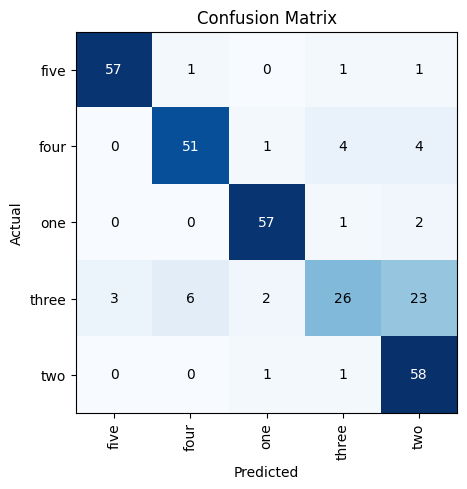

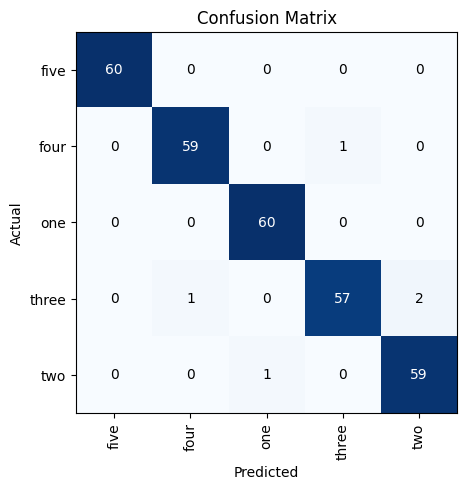

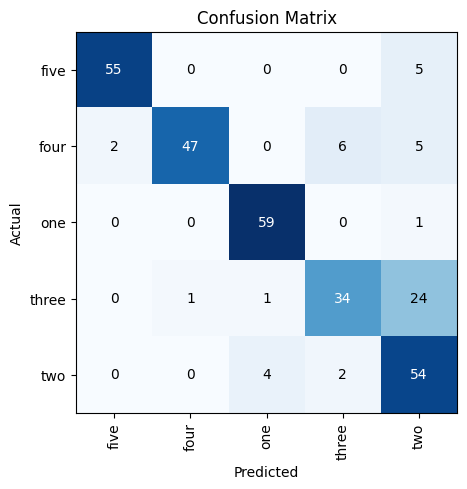

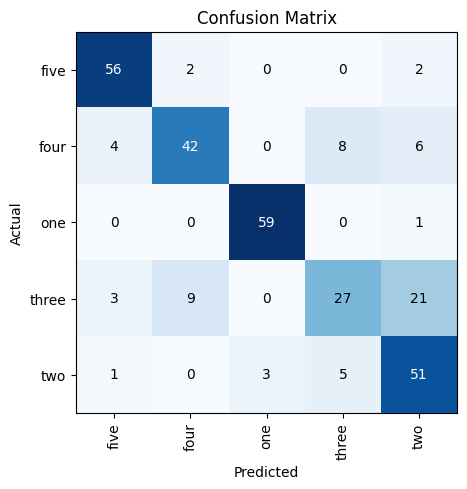

In [2]:
# Example: train_model(save_conf=False, epochs=0, base_model="vgg16", batch_size=32)
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/AlexNet.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/AlexNet.png", base_model="AlexNet")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=8, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/DenseNet121.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/DenseNet121.png", base_model="DenseNet121")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/EfficientNet_b0.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/EfficientNet_b0.png", base_model="EfficientNet_b0")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/EfficientNet_b1.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/EfficientNet_b1.png", base_model="EfficientNet_b1")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=12, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/GoogleNet.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/GoogleNet.png", base_model="GoogleNet")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/MnasNet0_5.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/MnasNet0_5.png", base_model="MnasNet0_5")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/MnasNet1_0.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/MnasNet1_0.png", base_model="MnasNet1_0")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/MobileNetV2.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/MobileNetV2.png", base_model="MobileNetV2")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/MobileNet_v3_small.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/MobileNet_v3_small.png", base_model="MobileNet_v3_small")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/ResNet18.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/ResNet18.png", base_model="ResNet18")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/ResNet50.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/ResNet50.png", base_model="ResNet50")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/SqueezeNet1_0.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/SqueezeNet1_0.png", base_model="SqueezeNet1_0")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/SqueezeNet1_1.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/SqueezeNet1_1.png", base_model="SqueezeNet1_1")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/VGG13_bn.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/VGG13_bn.png", base_model="VGG13_bn")
train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/VGG16.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/VGG16.png", base_model="VGG16")